# Monte Carlo Assignment
## The Stokes Flow

##### Laurent Pétré & Ilan Renous

In this assignment, we are going to generate random numbers with different distributions, simulate a brownian motion and simulate a model that predicts magnetism in a ferromagnetic material.

*!! Warning: This notebook takes about 10 minutes to compute. !!*

In [1]:
# We import the libraries we will need
import numpy
from matplotlib import pyplot
%matplotlib inline

## Random numbers

### Built-in Vs DIY Implementations

For the exponential distribution, we use the inverse function method. This method tells us that the function $$
F(x) = -\frac{1}{\alpha}\log(1-x).
$$
follows a exponential distribution when $x$ a is uniformly distributed in the interval $[0.1[$ .
We are going to compare this home-made distribution with a built in generator.

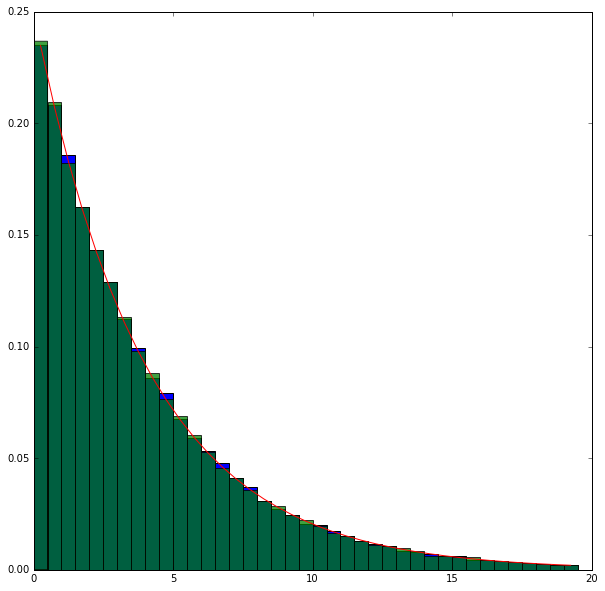

In [2]:
alpha = 0.25 # Rate of the exponential distribution

# Built-in generator
x = numpy.random.exponential(scale=1/alpha, size=100000)

# Inverse function
u = numpy.random.random_sample(100000)
y = -1/alpha*numpy.log(1-u)

# Plot
pyplot.figure(figsize=(10,10))
pyplot.xlim(0, 20)

binwidth = 0.5
bins = numpy.arange(0, 20, binwidth)
pyplot.hist(y, bins, normed=True);
pyplot.hist(x, bins, normed=True, alpha=0.75);

#Expected
bin_centers = bins[:-1] + binwidth/2
pyplot.plot(bin_centers, alpha*numpy.exp(-alpha*bin_centers))

We see that the two distribution give very similar random number distribution.

For the gaussian distribution, we will use the Von Neumann  rejection method. This method uses a set of random numbers with a given distribution $p_1(x)$, and then extracts from it a subset that obeys the desired distribution $p_2(x)$. In order for the method to work, there must exist a constant K such that we have, 

$$
{p_2(x)}\leq {Kp_1(x)},\quad \forall x.
$$

We can choose to generate a Gaussian distibution ($p_2(x)$), from an exponantial distribution ($p_1(x)$) since there exist such a constant $K$. This method will give us positive numbers. Let's use this method and compare it to the built in numpy metod.

The rejection method algorithm works as follows. 

1. We generate a number $x$ according to the exponential distribution.
2. We draw a random number $U$ between 0 and 1
3. We keep the number $x$ in our final set of randoms numbers if $U<\frac{p_2(x)}{Kp_1(x)}$.


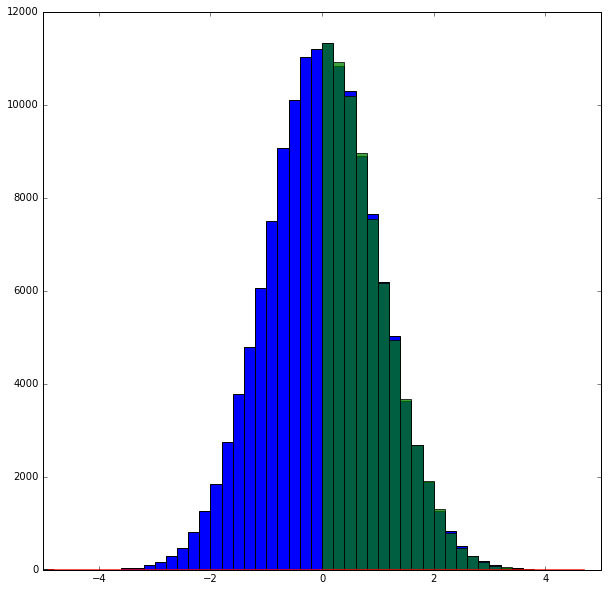

In [3]:
N = 100000 # Number of random numbers to draw
h=[] # Empty list for the final set of numbers

# Given Gaussian generator from the course with VNR method
for i in range(N):
    # Distribute g according to the exponential distribution
    u1 = numpy.random.random_sample()
    g = numpy.log(1/(1-u1))
    K = 1.4

    # Generate a second number for the acceptance/rejection condition
    u2 = numpy.random.random_sample()

    # Acceptance/rejection step
    ratio = 2*numpy.exp(-g**2/2.0)/numpy.sqrt(2*numpy.pi) / \
                (K*numpy.exp(-g))
    if (u2<ratio):
        # Append g to the set h
        h.append(g)

# Built-in generator
# We generate twice as much number as with the VNRM 
# to have to have a scaled histogram 
x = numpy.random.normal(loc=0, scale=1, size=2*len(h))

# Plot
pyplot.figure(figsize=(10,10))
pyplot.xlim(-5, 5)

binwidth = 0.2
bins = numpy.arange(-5, 5, binwidth)
pyplot.hist(x, bins, normed=False)
pyplot.hist(h, bins, normed=False, alpha=0.75)

#Expected
bin_centers = bins[:-1] + binwidth/2
pyplot.plot(bin_centers, \
    numpy.exp(-bin_centers**2/2.0)/numpy.sqrt(2*numpy.pi))

Once again, we can see that the random numbers genreated by the rejection method are really close to those generated by the built in generator.

### Box-Muller

Now, we are going to use another method to generate a gaussian distribution : the Box-Muller method.

This method can be summurized as follow :

We must first consider the product of two independant gaussian distributions for the sake of our calculation.

$$
f(x, y)=\frac{1}{2\pi} e^{-\frac{x^2+y^2}{2}}
$$

We consider the polar coordinates

$$x=r\cos(\theta)$$
$$y=r\sin(\theta)$$

From the central symmetry, $\theta$ is of course uniformly distributed in the interval $[0, 2\pi[$. With this fact, we can conclude that, for $x$ and $y$ distributed following a gaussian distribution, $r$ is distibuted following the relation:

$$r=\sqrt{-2\ln{u}}$$

Where u is a uniformly distributed variable in the interval $[0,1[$. If we generate $x$ and $y$ with those distrubution of $r$ and $\theta$, they will follow two independent gaussian distrubutions.


In Python that gives us :

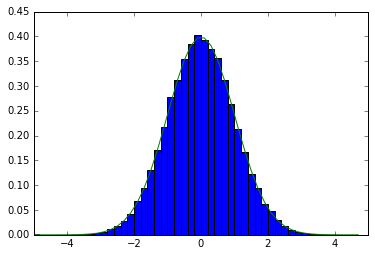

In [4]:
def box_muller(avg, stdev):
    """
    Box Muller implementation.

    Parameters
    ----------
    avg: float
        average of the gauss distribution

    stdev: float
        standard deviation of the gaussian

    Returns
    -------
    array[2]
        two independant numbers distributed following the requested gaussian
    """

    i = numpy.random.random_sample(2)
    r = numpy.sqrt(-2*numpy.log(i[0]))

    return avg + stdev * \
        r*numpy.array([numpy.cos(2*numpy.pi*i[1]), \
                        numpy.sin(2*numpy.pi*i[1])])

# We draw 100000 numbers
x = numpy.empty(100000)
for i in range(0, 50000):
    t = box_muller(0, 1)
    x[i] = t[0]
    x[50000 + i] = t[1]

# Plot
pyplot.xlim(-5, 5)

binwidth = 0.2
bins = numpy.arange(-5, 5, binwidth)
pyplot.hist(x, bins, normed=True);

#Expected
bin_centers = bins[:-1] + binwidth/2
pyplot.plot(bin_centers, \
        numpy.exp(-bin_centers**2/2.0)/numpy.sqrt(2*numpy.pi))

This method is very efficient and generate, like we can see on this graph, random numbers following a gaussian distribution.

## Brownian motion

The equation for the evolution of the position of a molecule of dye in water is:

$$
dx=x(t+dt)−x(t)=ds
$$

$ds$ is a displacement resulting from the collision with surrounding water molecules.

We will model $ds$ as
$$ ds=cdt+\sqrt{\alpha dt}\cal{N(0,1)} $$

where $\alpha$ is the same diffusion coefficient that one would use in the diffusion equation 

$$
\frac{\partial \rho}{\partial t}=\alpha \frac{\partial^2 \rho}{\partial x^2}
$$

With $\rho$ being the density of the dye.

Moreover, at each time step, $\cal{N(0,1)}$ is a random number that is generated from a normal  distribution $f(n)$, centered around $0$, and with variance equal to $1$. 

This is a deplacement forced by a random collision and by a systematic displacement $cdt$. This could model an electrons under a electric field "colliding" randomly with atoms in a metal.

To test our stochastic model and make the comparison with the diffusion equation, we initialise the position of our sample of molecules with a Gaussian distribution:

$$
P(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$ 

where $\sigma^2$ is the variance of the positions and $\mu$ is their average. As $n(x,0)=NP(x)dx$, we have $\rho(x,0)=P(x)$. In this case, the solution of the diffusion equation,

$$
\frac{\partial \rho}{\partial t}=\alpha \frac{\partial^2 \rho}{\partial x^2}
$$

can be computed exactly and is given by:

$$
P(x,t)=\frac{1}{\sqrt{2\pi\sigma_t^2}}e^{-\frac{(x-\mu_t)^2}{2\sigma_t^2}}
$$

with $\sigma^2_t = 2\alpha t + \sigma^2$ and $\mu_t=ct$.

We will follow the path of 100000 particules that are subject to this motion during a time  $T$. Let's see whats does the position distribution looks like at time $T$. If all goes well, we should recover this solution using our random walk technique.

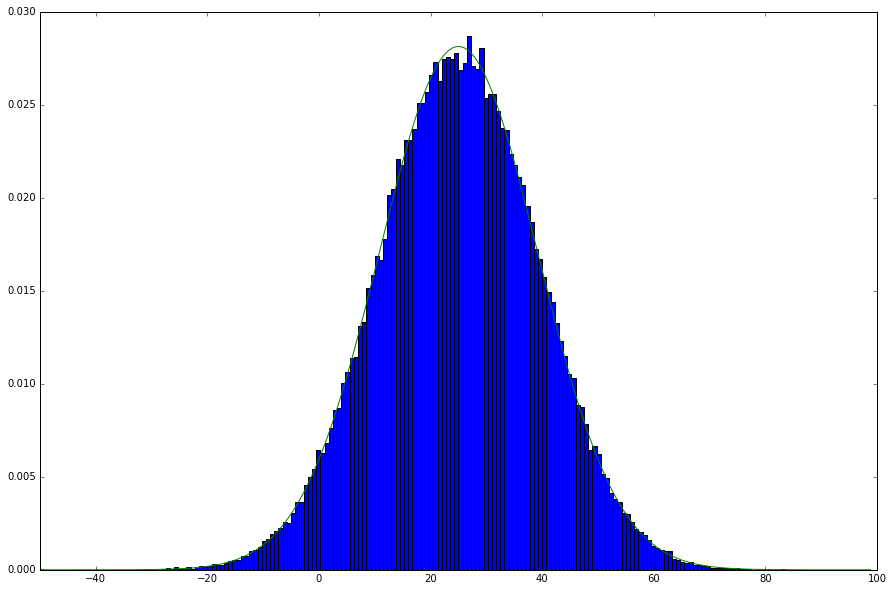

In [5]:
# Initial conditions
npart = 100000
mu = 0.
sigma = 1.

# Time to simulate
T = 50.
nt = 500
dt = T/nt

# System parameters
alpha = 2.
c = 0.5

# Generate a set of initial positions based on the Gaussian distribution
x = numpy.random.normal(loc = mu, scale=sigma, size=npart)

# Evolution
for i in range(nt):
    xi = x.copy()
    x = xi + c*dt + numpy.sqrt(2*alpha*dt)*numpy.random.normal(0, 1, npart)

# Plot
pyplot.figure(figsize=(15, 10))
pyplot.xlim(-50, 100)

binwidth = 0.75
bins = numpy.arange(-50, 100, binwidth)
pyplot.hist(x, bins, normed=True);

# Expected
mut = mu + c*T
sigmat2 = 2*alpha*T + sigma**2

bin_centers = bins[:-1] + binwidth/2
pyplot.plot(bin_centers, \
    numpy.exp(-(bin_centers - mut)**2/(2*sigmat2)) * \
    1/numpy.sqrt(2*numpy.pi*sigmat2))

It looks like the random walk algorithm gives a very similar to the exact solution.  The particles tend to spread away from each other and are "pushed" towards increasing x.

### Friction

We could also model the displacment $ds$ by 

$$ ds=-\gamma x dt +\sqrt{\alpha dt}\cal{N(0,1)} $$

this can be a model for a deplacement forced by a rondom collision with a friction term. We will analize the positions of the particules after a time $T$ with the same initial setup as before. We can show that the exact solution for the distribution is given by

$$
P(x,t)=\frac{1}{\sqrt{\frac{4\pi\alpha}{\gamma}(1-e^{-2\gamma t}x_0)}}e^{-\frac{(x-e^{-2\gamma t}x_0)^2}{4\alpha /\gamma}(1-e^{-2\gamma t})}
$$

Where $x_0$ is the initial distribution for the position, a normal distribution in our case. We can see that this goes for $t\rightarrow \infty$ to 

$$
P(x) = \frac{1}{\sqrt{4\pi\alpha /\gamma}}e^{-\frac{x^2}{\alpha /\gamma^2}}
$$ 

Which is a gaussian distribution with $\mu=0$ and $\sigma=2\alpha /\gamma$
We will analize the positions of the particules after a time $T$ very big with the same initial setup as before.

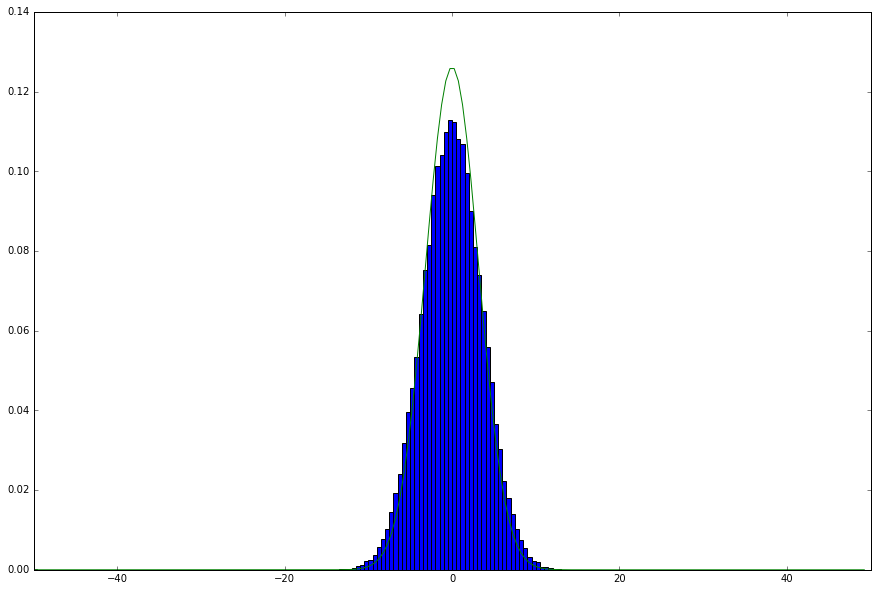

In [6]:
# Initial conditions
npart = 100000
mu = 0.
sigma = 1.

# Time to simulate
T = 150000
nt = 50000
#T1 = 15000
#T2 = 20000

# System parameters
alpha = 2.
gamma = 0.4

def friction(T, nt):
    dt = T/nt

    # Generate a set of initial positions based on the Gaussian distribution
    x = numpy.random.normal(loc = mu, scale=sigma, size=npart)

    # Evolution
    for i in range(nt):
        xi = x.copy()
        x = xi - gamma*xi*dt + \
            numpy.sqrt(2*alpha*dt)*numpy.random.normal(0, 1, npart)

    return x

x = friction(T, nt)
#x1 = friction(T1, nt)
#x2 = friction(T2, nt)

# Plot
pyplot.figure(figsize=(15, 10))
pyplot.xlim(-50, 50)

binwidth = 0.5
bins = numpy.arange(-50, 50, binwidth)
pyplot.hist(x, bins, normed=True);
#pyplot.hist(x1, bins, normed=True);
#pyplot.hist(x2, bins, normed=True, alpha=0.75)

# Expected
mut = mu
sigmat2 = 2*alpha/gamma

bin_centers = bins[:-1] + binwidth/2
pyplot.plot(bin_centers, \
    numpy.exp(-(bin_centers - mut)**2/(2*sigmat2)) * \
    1/numpy.sqrt(2*numpy.pi*sigmat2))

 We can see that they are really close. We can suppose that the distribution reaches a steady states as $t\rightarrow \infty$.

## Phase transition for ferromagnteic material

Using, the Metropolis algorithm, we are going to compute the magnetisation of a ferromagnetic material following the Ising model. We will prove that a metal, following this model, has different magnetic propreties before and after a temperature $T_c$. This temperature is called the the Curie temperature. 

### Ising model

In the Ising model of ferromagnetism, the material considered is described using dipoles, distributed on a regular lattice and that can either point upwards or downwards (see figure 1). These dipoles represent the atoms that constitute the material and act like magnets oriented in different directions.

<img src="lattice1.png" alt="Drawing" style="width: 300px;"/>
Figure 1

In the simplest version of the Ising model, all the dipoles interact with their nearest neighbors (left, right, above, below). When two neighbors are aligned, the system is in a more stable configuration than when they are aligned in opposite directions. The energy of the system can then be written as,

$$
E=-J\sum_{pairs(i,j)} s_i s_j
$$

where the sum runs over all the pairs of dipoles in the system and $s_i$ denotes the 'spin' of the $i$-th dipole which is equal to $1$ or $-1$ wether the dipole points upwards or downwards; $J>0$ is the coupling constant for each pair of dipoles. We thus see that the energy is minimized and equal to $-JN_{pairs}$ when all the dipoles point in the same direction.

For computation, we will adopt a non-dimensional unit system. 
Initially, our ferromagnetism problem has two parameters: the temperature $T$ and the coupling constant $J$. However, if we adopt as energy unit the product $k_b T$, our model has only one free parameter $\alpha=J/(k_b T)$ and the relevant formulas read:

$$
E = -{\alpha} \sum_{pairs(i,j)} s_i s_j
$$

In [7]:
def energy_at_site(sp, alpha, sigma, ix, iy):
    """
    Computes the contribution to the energy for a given spin
    at location ix,iy for a lattice with periodic boundary conditions
   
    Parameters:
    ----------
    sp: array[NxN]
        array of spins
    alpha: float
        coupling constant J/(kb*T)
    sigma: int
        spin at site ix, iy
    ix, iy: int
        x and y location
   
    Returns:
    -------
    energy: float
        energy for the given configuration
    """

    return -alpha*sigma*(sp[(ix-1)%nx,iy]+sp[(ix+1)%nx,iy]+sp[ix,(iy-1)%ny]+sp[ix,(iy+1)%ny])

According to statistical mechanics, the probability of finding the system in a given configuration $X$ is equal to,

$$
p(X) = \frac{e^{-\beta E_X}}{Z}
$$

where $E_X$ is the potential energy of the configuration and $\beta=1/k_B T$ where $k_B$ is the so-called Boltzmann constant. In other words, the higher the potential energy, the less likely it is to find the system in the corresponding configuration. In the above formula $Z$ is a normalisation constant such that $\sum_X p(X)=1$.

### The Metropolis algorithm

Let us consider an initial state in which each spin takes a random orientation.

The unit step of the Metropolis algorithm consists in choosing a random spin and in attempting to change its orientation. If the energy of the reversed spin decreases, the flipped state is chosen as the new configuration of the system.
Otherwise if the energy increases by $\Delta E$, the flip is only accepted with the probability,

$$
p_{\rm flip}=e^{-\Delta E},
$$

otherwise the current state is retained as the new configuration. This process is repeated until a large enough number of states $X_k$ has been collected.

With the formula above, we immediately see that each time a dipole is flipped, the energy changes by an amount equal to,

$$
\Delta E = -{\alpha} s_i \sum_{j \in n(i)} s_j
$$

where $n(i)$ denotes all the neighbors of the $i$-th dipole. $\Delta E$ is positive or negative depending on the sign of $s_i$ and the total spin of the neighbors.

The contribution to the energy coming from a change of spin at one site is computed with the following function. we assume that the system is periodic in both directions :

In [8]:
def metropolis_at_site(sp, alpha, ix, iy):
    """
    Flips a dipole at site ix, iy when probability condition is met.

    Parameters:
    ----------
    sp: arra[NxN]
        array of spins
    alpha: float
        coupling constant J/(kb*T)
    ix, iy: int
        x and y location
    """

    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (numpy.random.random_sample()<numpy.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]

The averages we are interested in, such as the energy or the magnetisation, are then computed according to,

$$
<E> = \frac{\sum_k E_k}{N_k}\\
<M> = \frac{\sum_k M_k}{N_k}
$$

where the sums run over all the states generated through the Metropolis algorithm and $N_k$ is the total number of them. And with $M_X=\sum_{i=1}^N s_i$ for the given state. Above the Curie temperature, one has $<M>=0$ while $<M>$ has a finite non vanishing value below the Curie temperature.

Compared to the averages over all possible states, we see here that we only sum over a subset of them. However, thanks to the Metropolis algorithm, the states corresponding to different values of the energy are generated with the right distribution function and the averages above converge to the equilibrium values as $N_k\rightarrow \infty$.

In [9]:
def energy_array(sp, alpha):
    """
    Computes the energy lattice from a spin lattice.
   
    Parameters:
    ----------
    sp: array[NxM]
        array of spins

    alpha: float
        coupling constant
   
    Returns:
    -------
    array[NxM] of float
        energy lattice for the given configuration
    """

    return -alpha*sp[:, :]* \
        (numpy.roll(sp, 1, axis=0) + numpy.roll(sp, -1, axis=0) + \
         numpy.roll(sp, 1, axis=1) + numpy.roll(sp, -1, axis=1))

def total_energy(sp, alpha):
    """
    Computes the total energy of the lattice.
   
    Parameters:
    ----------
    sp: array[NxM]
        array of spins

    alpha: float
        coupling constant

    Returns:
    -------
    float
        total energy for the given configuration
    """

    return energy_array(sp, alpha).sum()

def total_magnetization(sp):
    """
    Computes the total magnetiaztion of the lattice.
   
    Parameters:
    ----------
    sp: array[NxM]
        array of spins
   
    Returns:
    -------
    float
        magnetization for the given configuration
    """

    return sp.sum()

### Implementation
We will run the metropolis algorithm on all the sites.

In [10]:
def ising_model_metropolis(sp, alpha, NMC):
    """
    Creates a sequence of states for the Ising model using
    the Metropolis algorithm.

    Parameters:
    ----------
    sp: array[NxN]
        initial lattice state
    alpha: float
        coupling constant J/(kb*T)
    NMC: int
        number of states to create

    Returns:
    -------
    states: array[NMC+1xNxN]
        sequence of states
    """

    size = sp.shape
    nx = size[0]
    ny = size[1]

    states = numpy.empty([NMC+1,nx,ny])
    states[0] = sp.copy()

    for i in range(1,NMC+1):
        for j in range(0,nx*ny):
            ix=numpy.random.random_integers(0,nx-1)
            iy=numpy.random.random_integers(0,ny-1)
            metropolis_at_site(sp,alpha,ix,iy)
        states[i]=sp.copy()

    return states

### Value of $\alpha$ for the phase transition


Now we will look at the result of this method for varying $\alpha$. For each result, we will then evaluate the energy and the magnetisation of the final state. There should be a break in the magnetization of the final state around a the $\alpha$ corresponding to the temperature $T_c$. In term of $\alpha$ this temperature is expressed as $T_c= J/k_b \alpha$.

In [11]:
def ising_model_metropolis_for_alphas(spi, alphas, NMC):
    """
    Creates a sequence of states for the Ising model using
    the Metropolis algorithm.

    Parameters:
    ----------
    spi: array[NxN]
        initial lattice state
    alphas: list of float
        coupling constant J/(kb*T)
    NMC: int
        number of states to create

    Returns:
    -------
    energy: list of floats
        average energy for asked alphas
    magn: list of floatsµ
        average magnetization for asked alphas
    """

    size = alphas.shape
    na = size[0]

    energy = numpy.zeros(na)
    magn = numpy.zeros(na)

    for i in range(0, na):
        sp = spi.copy()
        states = ising_model_metropolis(sp, alphas[i], NMC)
        for j in range(25, NMC+1):
            energy[i] += total_energy(states[j], alphas[i])/(NMC+1-25)
            magn[i] += numpy.abs(total_magnetization(states[j])/(NMC+1-25))

    return energy, magn

We set the different parameters of our grid and the range of $\alpha$ as follow:

In [12]:
NMC = 100 #number of iteration for metropolis
nx = 100 #size of the grid
ny = 100

na = 25  # nummber of step for the value aplha
alpha_min=0. #range for alpha
alpha_max=1.
alpha = numpy.linspace(alpha_min, alpha_max, na)

We will first compute the evolution of the magnetization and the energy for a system where, initially, all spins are pointing upwards. The green line shows the magnetisation, and the blue line the energy.

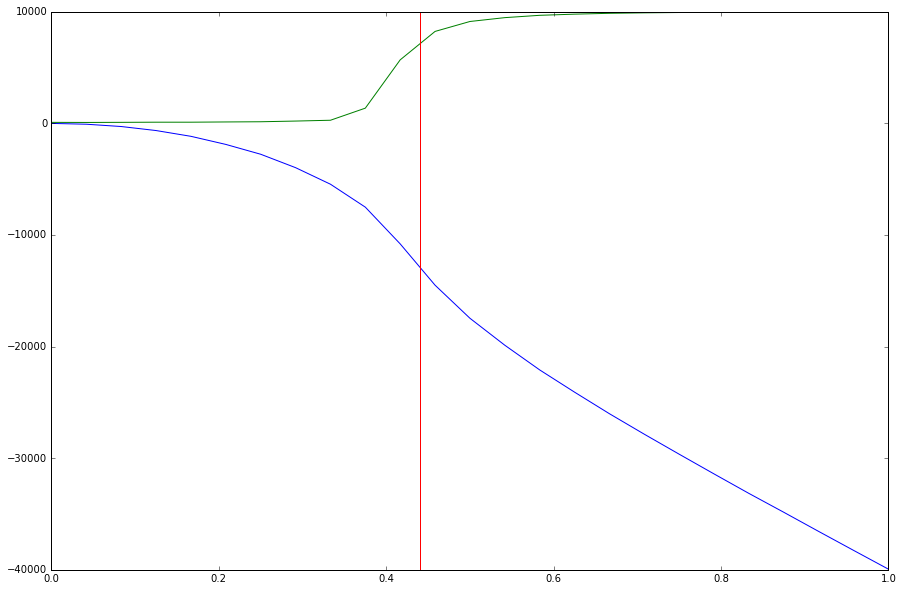

In [13]:
spi = numpy.ones([nx, ny]) #initial condition of all spin up

energy, magn = ising_model_metropolis_for_alphas(spi, alpha, NMC) 

pyplot.figure(figsize=(15, 10))
pyplot.plot(alpha, energy)
pyplot.plot(alpha, magn)
pyplot.axvline(0.4406867935, color='red')

We can clearly see that something happens around $\alpha=0.45$. At this value of $\alpha$, the final states goes from almost not magnetize to a maximum magnetization around 10000. This clearly shows a phase transition between two states for a ferromagnetic material.

The Onsager's solution for the value of $T_c$ for the Ising model is 

$$T_c=\frac{2J}{k_b\ln(1+\sqrt{2})}$$

We extract $\alpha$ at this temperature

$$\alpha_c=\frac{ln(1+\sqrt{2})}{2}$$

which is illustrated by the red line which match our simulated value.

We can run this algorithm for a different initial distribution of spin. We chose this distribution to be random inside the grid and pointing upward on the edge of the grid. We should ge approximately the same relsult for $\alpha_c$

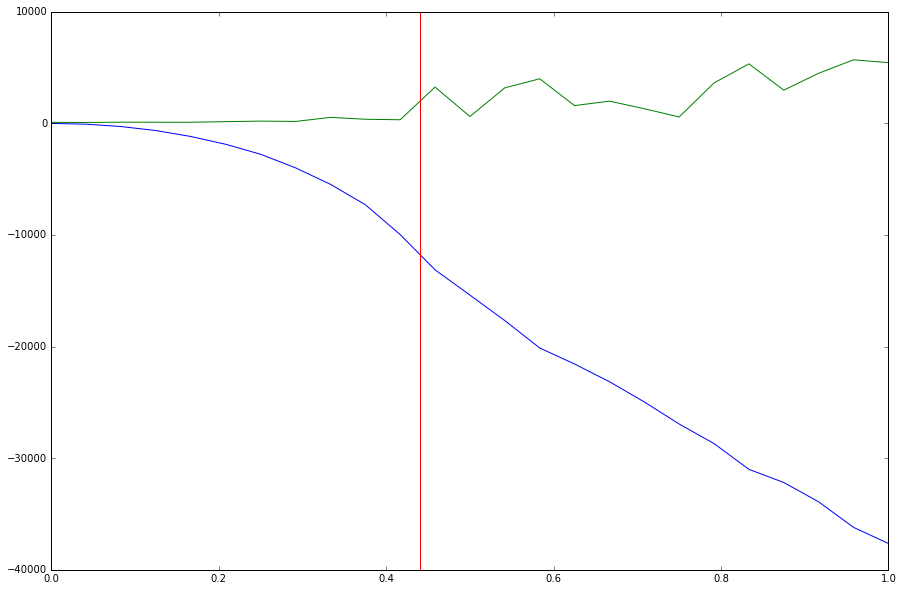

In [14]:
spi = numpy.ones([nx, ny])
spi[1:-1,1:-1] = numpy.where(numpy.random.random_sample((nx-2, ny-2)) < 0.5, -1, 1)

energy, magn = ising_model_metropolis_for_alphas(spi, alpha, NMC)

pyplot.figure(figsize=(15, 10))
pyplot.plot(alpha, energy)
pyplot.plot(alpha, magn)
pyplot.axvline(0.4406867935, color='red')

It looks like there is a problem. This might be because the set of data is not big enough to give the predicted result.

## Conclusion

We saw that generating random numbers following different distributions could be easily done with the Von Neumann rejection method. Although, to be efficient, the choice of the distribution used needs to be done in order to minimizes rejected data. If the distribution is invertible, the invertion method is very easy to implement and efficient but, the inverse function might be hard to find.

The random walk method is a very efficient way to model the diffusion process. It can also model stochastic event such as stock prices. As soon as the complexity of the model for a small displacement increases, finding the analytical solution become almost impossible. This is why it is very usefull to compute those processes with numerical methods.

It was also interesting to see the preidction power of a relatively simple model that is the Ising model. The phase transition is remarkably well predicted with an initial magetized state, but not at all with a random initial state. this might be due to a grid size not sufficiently big. This algorithm could be computed for a way larger grid and with a bigger number of iteration but it has not been done because the computation was far too long.

##### Source

(1) We used the following lectures https://github.com/bknaepen/numerical-mooc, Branch Monte-Carlo, available under Creative Commons Attribution license CC-BY 4.0, (c)2014 L.A. Barba, C. Cooper, G.F. Forsyth, A. Krishnan, B. Knaepen.

---
###### The cell below loads the style of this notebook. 

In [15]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())